# Spectral Analysis and Fourier Transform

As we prepare ourselves for more advanced algorithms in time series forecasting we now look at one of the most common used pre-processing methods in handling time-series data - Spectral Analysis.

Spectral Analysis (or analysis in the frequency-domain) focuses on the underlying periodic behavior of our signals. Normally we represent our signals in the time-domain, that is, we measure our values over time. In this chapter we will transform our signals from the time-domain to our frequency-domain using Fourier Transform.

Quick note that we will not be explicitly forecasting using the results of our Spectral Analysis, but rather, it will help us uncover underlying patterns, seasonalities, and cyclic behaviors from our data.

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import pandas as pd
import pywt
import os
import warnings
warnings.filterwarnings('ignore')

## The Fourier Transform

**Fourier Transform or FT** breaks down our signal into its components in the frequency-domain given by:

\begin{align} \hat{y}(\omega) = \int_{-\infty}^{\infty}{y(t)e^{-2\pi i \omega t}d\omega} \end{align}

This is based on the underlying principle that any signal can be broken down into a superposition of sinusoid waves also known as the Fourier Series. However, there is are a few assumptions before we apply fourier transform to our data; specifically:
1. The signal does not have any trend - This means that our signal is not increasing or decreasing with time.
2. The signal used is assumed to be cyclically repeating beyond the range given.

Given this, let's look at examples to understand this better.

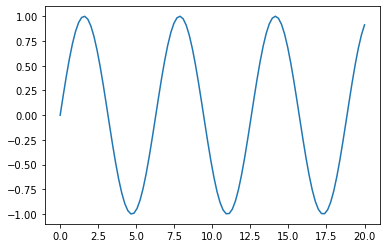

In [11]:
# Fourier Transform of a simple sine wave
x = np.linspace(0,20,100)
y = np.sin(x)
plt.plot(x,y)
plt.show()

This is our simple sine wave. *Given our definition of the Fourier series, how many terms or components would this wave have in the frequency domain?*

To verify our answer, let's now perform the Fourier Transform.

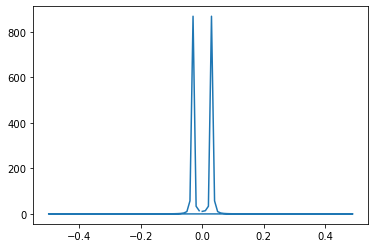

In [14]:
y_fft = scipy.fft.fft(y)
freqs = scipy.fft.fftfreq(x.shape[-1])
plt.plot(freqs,y_fft.real**2)

Note that given this signal, we can see two peaks, one positive and one negative. The negative sign simply represents the reflection of our signal an denotes forward and backward phase - which is not important for us right now. What we are interested in is the location of the peaks. At this point, we can see that we have one peak corresponding to the frequency of our signal.

*Next question is, how do we interpret this frequency given our data?*

This will depend on the context of our original data so we need to establish sampling rate of our original signal to make this interpretable. Let's try one out using a function that parametrizes our sinusoid.

In [15]:
def sine_wave(amp=1, freq=1, sample_rate=300, duration=5,
              plot=True, shift=0, noise=0):
    x = np.linspace(0, duration, sample_rate*duration)
    frequencies = x * freq
    y = amp*np.sin((2 * np.pi * frequencies) + shift) + noise
    if plot:
        plt.subplots(figsize=(15, 2))
        plt.plot(x, y)
        plt.show()
    return x, y

For this part, let's add two sine waves and check it's fourier transform:

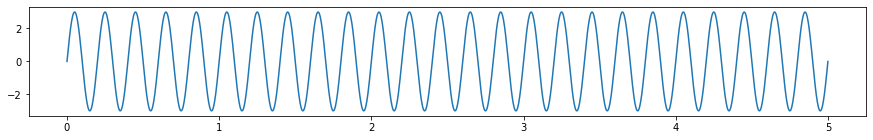

In [202]:
x1,y1 = sine_wave(3,5,300,5)

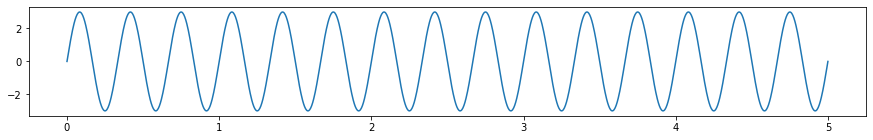

In [201]:
x2,y2 = sine_wave(3,3,300,5)

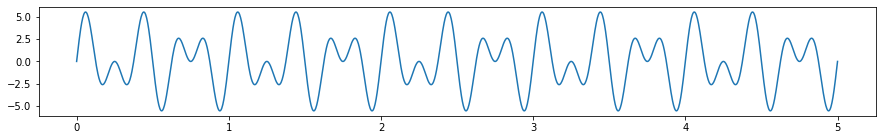

In [203]:
y3 = y1+y2
plt.subplots(figsize=(15, 2))
plt.plot(x1,y3)

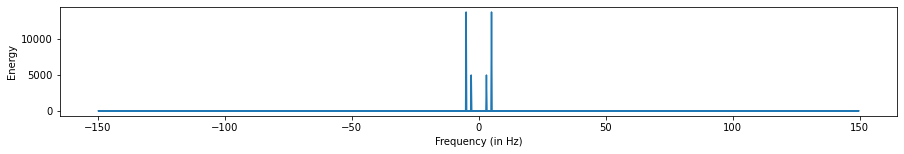

In [204]:
y_fft = scipy.fft.fft(y3)
sample_rate = 300
freqs = scipy.fft.fftfreq(x1.shape[-1])*sample_rate
plt.subplots(figsize=(15, 2))
plt.ylabel('Energy')
plt.xlabel('Frequency (in Hz)')
plt.plot(freqs,y_fft.real**2)

Now, we can see here that our plot has two peaks given by 5 Hz and 3 Hz, which is the same as the two sine waves that we have defined. The y-axis of the Fourier Space can be interpreted as the energy of each component. This is now the *spectral density* or the *power spectrum* of our signal. We can solve this analytically by computing for the total area under the squared values of our original signal.

The great thing about Fourier Transform is that it is reversible. We can recover the original signal by performing an inverse fourier transform.

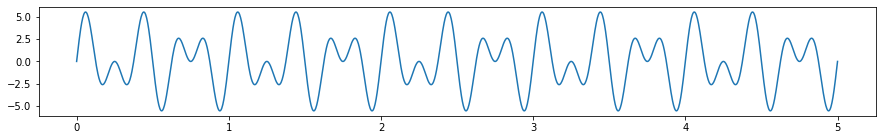

In [205]:
y_rec = scipy.fft.ifft(y_fft)
plt.subplots(figsize=(15, 2))
plt.plot(x1,y_rec)

*How can we now use this for our time series analysis?*

## Filtering by Energy

Let's take a look at one example given our discussion from the previous sessions:

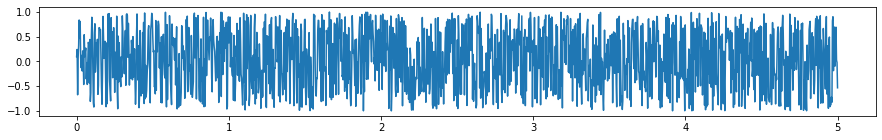

In [206]:
noise = np.random.uniform(-1,1,len(y3))
plt.subplots(figsize=(15, 2))
plt.plot(x1,noise)

What do you think will be the fourier transform of this noise?

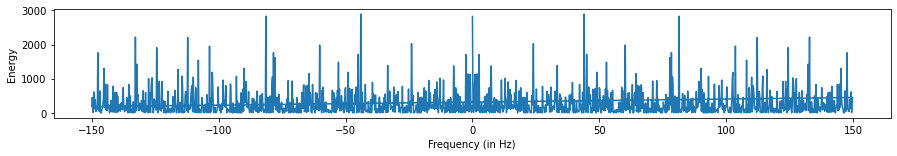

In [207]:
n_fft = scipy.fft.fft(noise)
sample_rate = 300
freqs = scipy.fft.fftfreq(x1.shape[-1])*sample_rate
plt.subplots(figsize=(15, 2))
plt.ylabel('Energy')
plt.xlabel('Frequency (in Hz)')
plt.plot(freqs,n_fft.real**2)

*We can actually several peaks here, but what can you say about the location of these peaks?*

Now let's try adding this noise to our original signal.

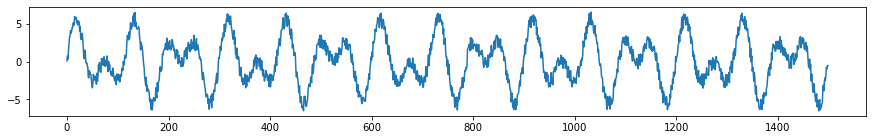

In [208]:
y4 = noise + y3
plt.subplots(figsize=(15, 2))
plt.plot(y4)

Although we can still see the pattern of the signal, it is not as clean as our original construction. Let's now look at its fourier transform:

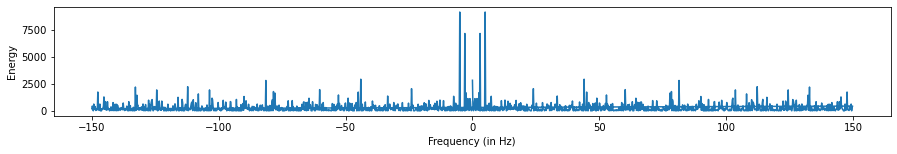

In [209]:
y4_fft = scipy.fft.fft(y4)
sample_rate = 300
freqs = scipy.fft.fftfreq(x1.shape[-1])*sample_rate
plt.subplots(figsize=(15, 2))
plt.ylabel('Energy')
plt.xlabel('Frequency (in Hz)')
plt.plot(freqs,y4_fft.real**2)

We can still see a lot of peaks here but it is obvious that we have dominating spikes. To remove that noise, what we can do is to filter out low-energy frequencies from our fourier transform and reconstruct our signal using the filtered spectrum. By eyeballing the graph, we can guess that the important peaks is above 5000, let's use this as a threshold and zero out the rest of the frequencies.

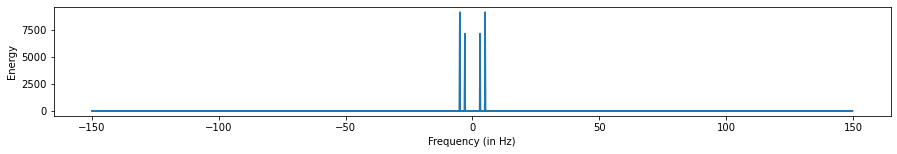

In [210]:
y4_fft_denoised = [0 if x.real**2 < 5000 else x.real for x in y4_fft]
plt.subplots(figsize=(15, 2))
plt.ylabel('Energy')
plt.xlabel('Frequency (in Hz)')
plt.plot(freqs,np.array(y4_fft_denoised)**2)

Given this signal, let's reconstruct our original graph:

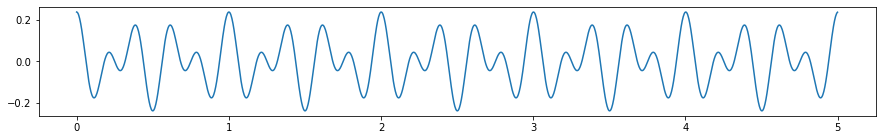

In [211]:
y4_rec = scipy.fft.ifft(y4_fft_denoised)
plt.subplots(figsize=(15, 2))
plt.plot(x1,y4_rec)

Comparing this to our original data, we can see that we have successfully denoised our dataset and we are able to see the underlying pattern more clearly.

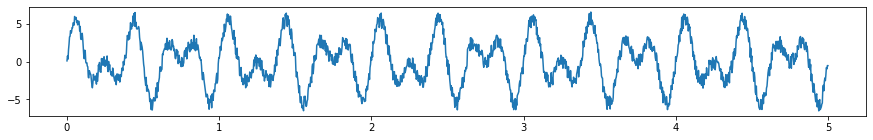

In [212]:
plt.subplots(figsize=(15, 2))
plt.plot(x1,y4)

*Instead of setting a threshold by eyeballing the graph, what else can we do to set the treshold automatically?*

## Filtering by frequency

Now, imagine if we have data on sales collected weekly, but we want to look at the pattern per month, how can fourier transform help us with this?

We can instead use the frequencies themselves as a filter for our fourier transform. There are three types of filter based on frequency:
- high-pass filter
- low-pass filter
- band-pass filter

Let's illustrate the first two:

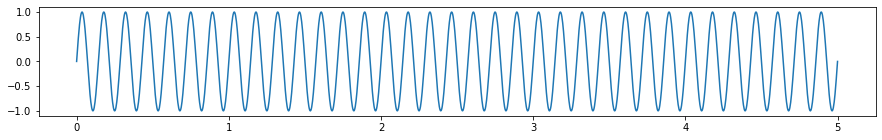

In [226]:
x1,y1 = sine_wave(1,7,364)

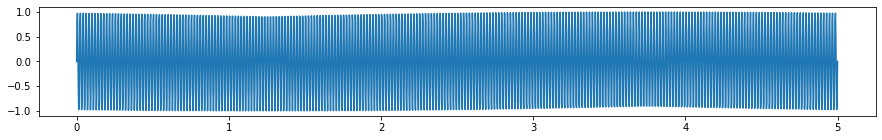

In [227]:
x2,y2 = sine_wave(1,52,364)

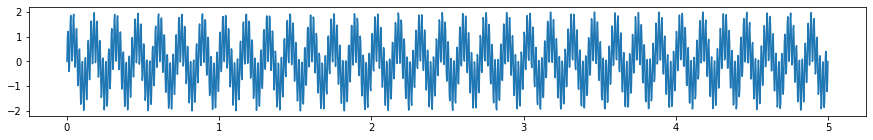

In [228]:
y3 = y1+y2
plt.subplots(figsize=(15, 2))
plt.plot(x1,y3)

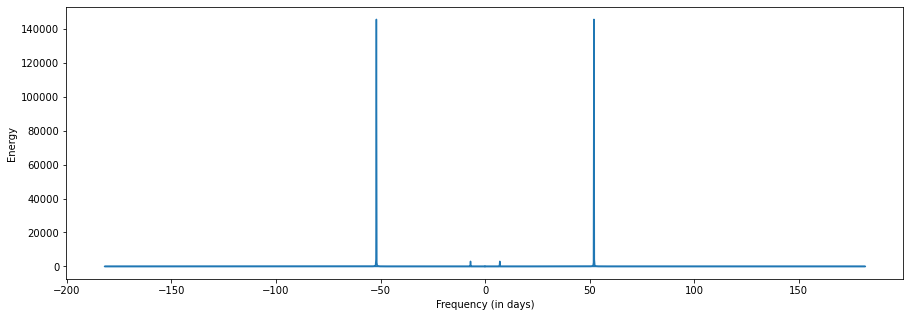

In [239]:
y_fft = scipy.fft.fft(y3)
sample_rate = 364
freqs = scipy.fft.fftfreq(x1.shape[-1])*sample_rate
plt.subplots(figsize=(15, 5))
plt.ylabel('Energy')
plt.xlabel('Frequency (in days)')
plt.plot(freqs,y_fft.real**2)

Looking at the fourier transform, it is obviously dominated by our high frequency signal (this makes sense physically since high frequency signal have higher energies). Notice that in this case, our sampling is in days instead of Hz. We can now use these frequencies to filter out our signal.

In [241]:
freqs

array([ 0. ,  0.2,  0.4, ..., -0.6, -0.4, -0.2])

In [244]:
high_pass = y_fft.copy()
high_pass[abs(freqs)<25]=0

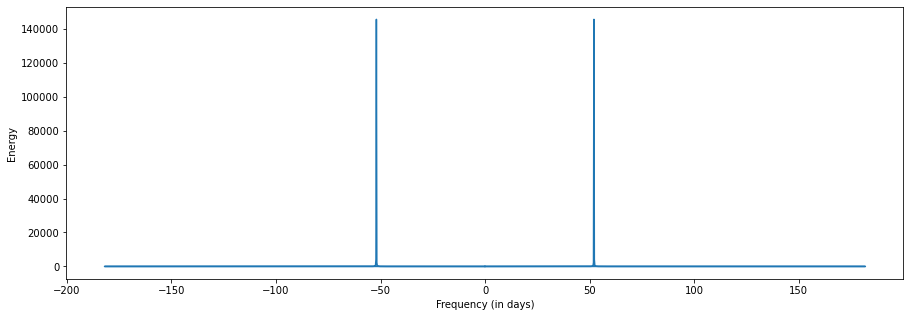

In [245]:
plt.subplots(figsize=(15, 5))
plt.ylabel('Energy')
plt.xlabel('Frequency (in days)')
plt.plot(freqs,high_pass.real**2)

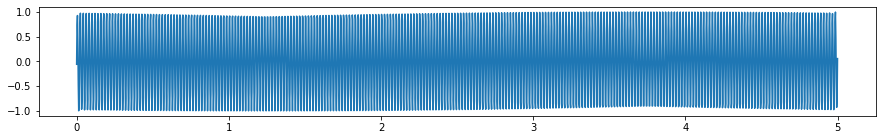

In [247]:
high_pass_rec = scipy.fft.ifft(high_pass)
plt.subplots(figsize=(15, 2))
plt.plot(x1,high_pass_rec)

We've managed to get the daily data just using the high-pass filter. We can do the same using a low-pass filter to get the low-frequency signal:

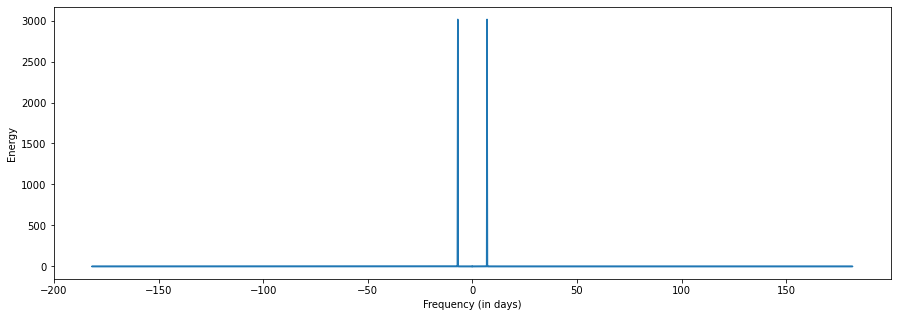

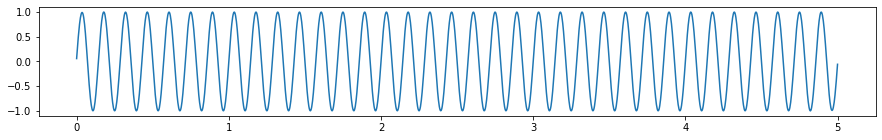

In [248]:
low_pass = y_fft.copy()
low_pass[abs(freqs)>25]=0

plt.subplots(figsize=(15, 5))
plt.ylabel('Energy')
plt.xlabel('Frequency (in days)')
plt.plot(freqs,low_pass.real**2)

low_pass_rec = scipy.fft.ifft(low_pass)
plt.subplots(figsize=(15, 2))
plt.plot(x1,low_pass_rec)

*Based on the name itself, what do you think will a band-pass filter do to our data?*

## Example: Household Power Consumption

Now let's try to look at the Household Power Consumption data presented in the previous topic. Let's see if we can uncover patterns in our data using spectral analyis.

In [259]:
# Preparing our data:
df = pd.read_csv('household_power_consumption.txt',
                 sep=';',
                 parse_dates={'dt': ['Date', 'Time']},
                 infer_datetime_format=True,
                 low_memory=False,
                 na_values=['nan', '?'],
                 index_col='dt')

df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2075259 entries, 2006-12-16 17:24:00 to 2010-11-26 21:02:00
Data columns (total 7 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Global_active_power    float64
 1   Global_reactive_power  float64
 2   Voltage                float64
 3   Global_intensity       float64
 4   Sub_metering_1         float64
 5   Sub_metering_2         float64
 6   Sub_metering_3         float64
dtypes: float64(7)
memory usage: 126.7 MB


In [260]:
df.isnull().sum()

Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64

In [261]:
# fill missing values using forward-fill
df.ffill(axis=0, inplace=True)
df.isnull().sum()

Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

In [262]:
# Perform data processing
eq1 = (df['Global_active_power'] * 1000 / 60)
eq2 = df['Sub_metering_1'] + df['Sub_metering_2'] + df['Sub_metering_3']
df['power_consumption'] = eq1 - eq2
df['dateday'] = pd.to_datetime(df.index, format="%Y-%m-%d;%H:%M:%S")
df.head()
data = df.copy()

# Filter out 2006 data
df_subset = data[data.index.year>2006]
df_subset.shape

# Grouped on Date columnby Day (based on monthly consumption)
df_subset = df_subset.groupby(pd.Grouper(key='dateday',freq='M')).sum()

# Subset of only power consumption column
df_power_consumption = df_subset[['power_consumption']]
print(df_power_consumption.info())
df_power_consumption.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 47 entries, 2007-01-31 to 2010-11-30
Freq: M
Data columns (total 1 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   power_consumption  47 non-null     float64
dtypes: float64(1)
memory usage: 752.0 bytes
None


power_consumption
dateday                      
2007-01-31      684969.166667
2007-02-28      559086.966667
2007-03-31      525150.900000
2007-04-30      346888.366667
2007-05-31      356164.200000

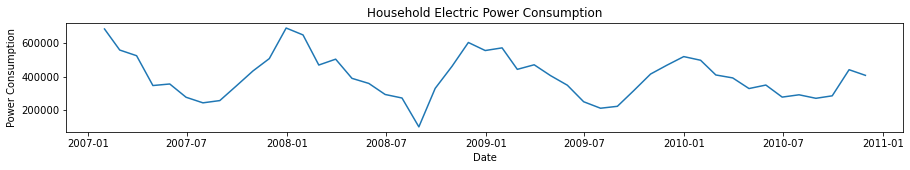

In [284]:
# Plotting our time-series
plt.subplots(figsize=(15, 2))
plt.title("Household Electric Power Consumption")
plt.xlabel('Date')
plt.ylabel('Power Consumption')
plt.plot(df_power_consumption['power_consumption'],label='Power_Consumption')
plt.show()

Based on the graph, what do you think will be the seasonality of our dataset?

In [280]:
y = df_power_consumption['power_consumption'].values

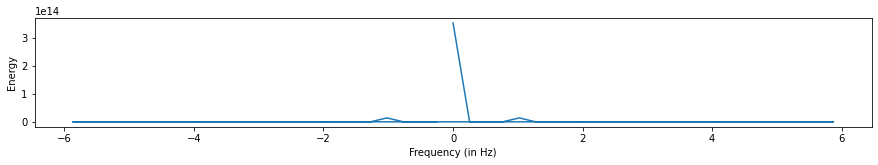

In [281]:
power_fft = scipy.fft.fft(y)
freqs = scipy.fft.fftfreq(y.shape[-1], d=1/12)
plt.subplots(figsize=(15, 2))
plt.ylabel('Energy')
plt.xlabel('Frequency (in Hz)')
plt.plot(freqs,power_fft.real**2)

What do you notice with the graph? It is dominated by a DC component (frequency = 0), we can remove this by filtering our high energy signals.

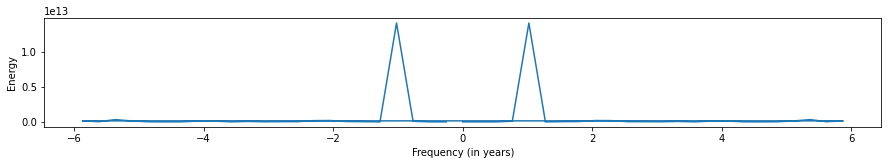

In [285]:
power_fft_denoised = [0 if x.real**2 > 1e14 else x.real for x in power_fft]
plt.subplots(figsize=(15, 2))
plt.ylabel('Energy')
plt.xlabel('Frequency (in years)')
plt.plot(freqs,np.array(power_fft_denoised)**2)

We can now observe that we have a peak at year = 1. This is in line with the previous discussion where we saw a peak in our partial autocorellation graph equal to 12 months. We can then reconstruct our dataset using inverse fourier transform to see the pattern in our data:

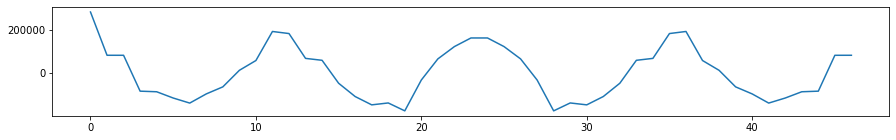

In [283]:
power_rec = scipy.fft.ifft(power_fft_denoised)
plt.subplots(figsize=(15, 2))
plt.plot(power_rec)

Again, we would like to reiterate that although we're not explicitly predicting the values of the time-series, fourier transform helps us instead by preparing our datasets to uncover underlying cyclical patterns that might not be immediately obvious. This can be used as a preprocessing technique for our forecasting methods.

### Example 2: Visual Application of Fourier Transform - Lunar Orbital

This example visually illustrates how Fourier Transform can actually be used on signals outside the time-domain. In this case, we look at signals across space - i.e. an image. We first plot an image using skimage.

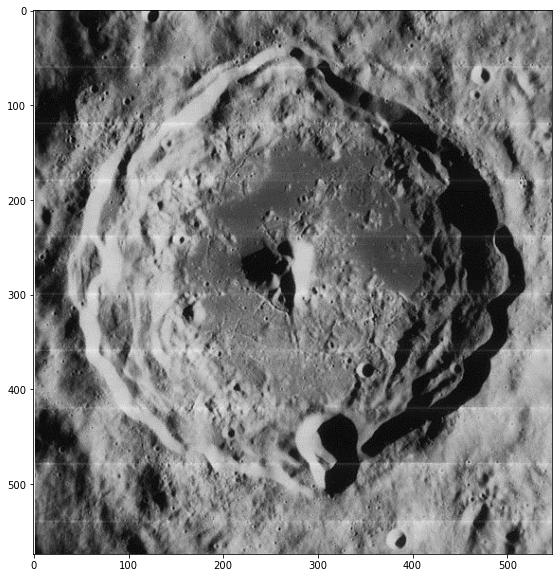

In [294]:
from skimage.io import imread, imshow
from skimage.color import rgb2gray
orbiter = rgb2gray(imread('lunar_orbiter.jpg'))
plt.subplots(figsize=(10,10))
plt.imshow(orbiter,cmap='gray')

We can notice that we have a periodic noise in this image. We can remove this using fourier transform!

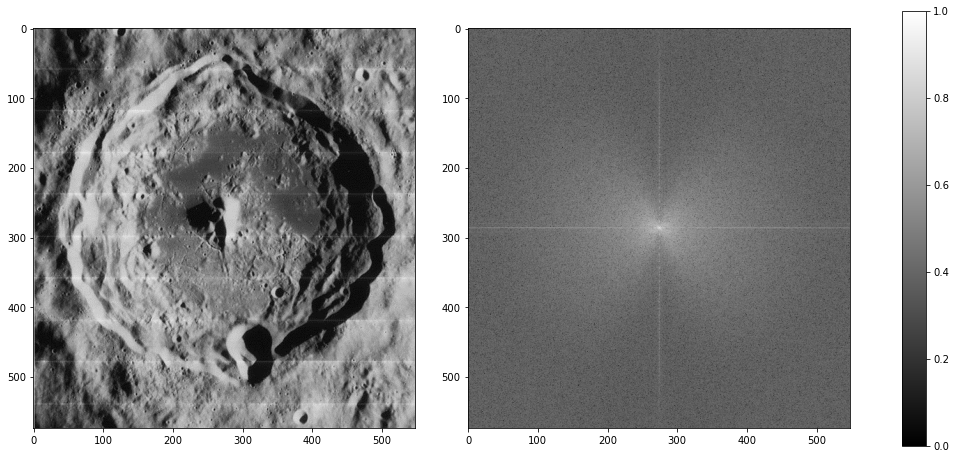

In [295]:
orbiter_fft = np.fft.fftshift(np.fft.fft2(orbiter))

fig, ax = plt.subplots(1, 3, gridspec_kw=dict(width_ratios=[16,16,1]),figsize=(16,8))
img = ax[0].imshow(orbiter, cmap='gray')
ax[1].imshow(np.log(abs(orbiter_fft)), cmap='gray')
fig.colorbar(img, cax=ax[2]);

Notice that in this Fourier Transform, we have a vertical band at the center. We can mask this to remove the periodic signal across the vertical.

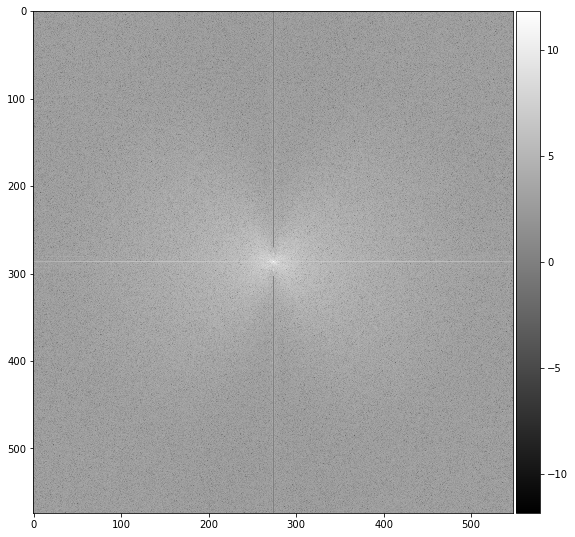

In [301]:
orbiter_fft2 = orbiter_fft.copy()
orbiter_fft2[:270,orbiter_fft.shape[1]//2] = 1
orbiter_fft2[-270:,orbiter_fft.shape[1]//2] = 1
plt.subplots(figsize=(8,8))
imshow(np.log(abs(orbiter_fft2)), cmap='gray');

And getting the inverse Fourier Transform of our image will give us:

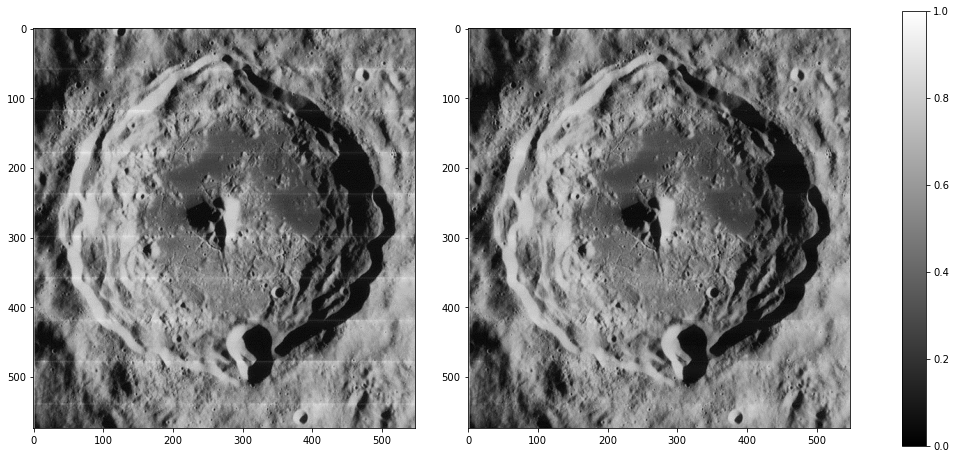

In [300]:
fig, ax = plt.subplots(1, 3, gridspec_kw=dict(width_ratios=[16,16,1]),figsize=(16,8))
img = ax[0].imshow(orbiter, cmap='gray')
ax[1].imshow(abs(np.fft.ifft2(orbiter_fft2)), cmap='gray')
fig.colorbar(img, cax=ax[2]);

## Wavelet Transform

One of the main limitations of the Fourier Transform is the assumption that the sinusoidal components is true or existing across the entire time-series. What if the signal that we are looking for is a "pulse" or a momentary or abrupt instance of a certain structure? This is where Wavelet Transform comes in.

**Wavelet Transform or WT** measures how much of the certain wavelet appears in the signal. While both WT and FT operate in the frequency domain, wavelet transform also gives information regarding our time domain. The Transformation is done by sliding your reference wavelet (called the "mother wavelet") across your signal. While sliding the wavelet, we also vary the size of the wavelet based on a scale factor.

We then measure the wavelet transform after sliding given by:

$\begin{align} WT(y(t)) = \frac{1}{\sqrt{|\sigma|}}\int_{-\infty}^{\infty}y(t)\psi \left( \frac{t-h}{\sigma} \right)dt \end{align}$

where $y(t)$ is the time series, $\sigma$ is the scale, $h$ is the time lag/translation, and $\psi$ is the mother wavelet. 

From the WT, we obtain sets of coefficients corresponding to different time lags and scales. The greater the magnitude of the coefficients, the greater overlap there is between the scaled, time-shifted mother wavelet and the time series.

In [302]:
def rescale(arr, scale=2):
    n = len(arr)
    return np.interp(np.linspace(0, n, scale*n+1), np.arange(n), arr)

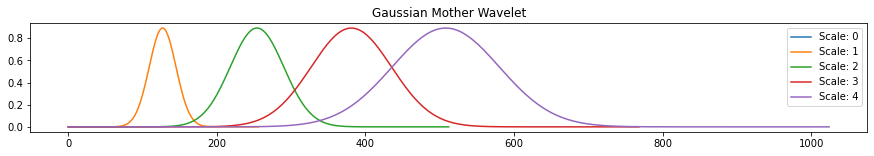

In [303]:
fig, ax = plt.subplots(figsize=(15, 2))
wav1 = pywt.ContinuousWavelet('gaus1')
int_psi1, x = pywt.integrate_wavelet(wav1)
for s in range(5):
    ax.plot(rescale(int_psi1, scale=s), label='Scale: '+ str(s))
    ax.legend()
    ax.set_title('Gaussian Mother Wavelet')

Suppose we have a signal of repearing Gaussian waves. Applying the WT on this signal using a mother wavelet corresponding to that of a Gaussian wavelet, we can pinpoint where the time series exhibits a Gaussian-like pattern.

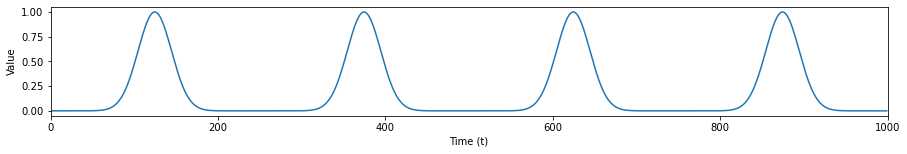

In [305]:
s1 = list(scipy.signal.gaussian(250, std=20))
s1 = np.tile(s1, 4)
plt.subplots(figsize=(15, 2))
plt.xlim(left=0, right=1000)
plt.ylabel('Value')
plt.xlabel('Time (t)')
plt.plot(s1)
plt.show()

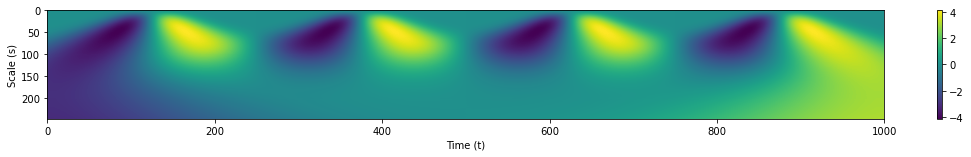

In [306]:
coeffs, freqs = pywt.cwt(s1, range(1,250), wavelet='gaus1')
plt.subplots(figsize=(18.75, 2))
plt.xlim(left=0, right=1000)
plt.ylabel('Scale (s)')
plt.xlabel('Time (t)')
plt.imshow(coeffs, aspect='auto')
plt.colorbar();

By observing where the magnitudes of the WT are greatest, we can pinpoint the time and scale wherein there is Gaussian-like behavior in our time series. The WT is also useful in sifting out our signal from noise. We apply white noise once more to our Gaussian pulses and observe the WT's results.

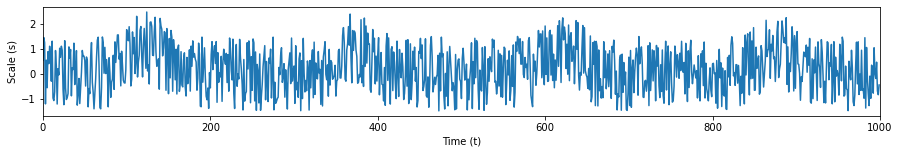

In [311]:
s1 = list(scipy.signal.gaussian(250, std=20))
noise = np.random.uniform(-1.5,1.5,4*len(s1))
s1 = np.tile(s1, 4) + noise
plt.subplots(figsize=(15, 2))
plt.xlim(left=0, right=1000)
plt.ylabel('Scale (s)')
plt.xlabel('Time (t)')
plt.plot(s1)
plt.show()

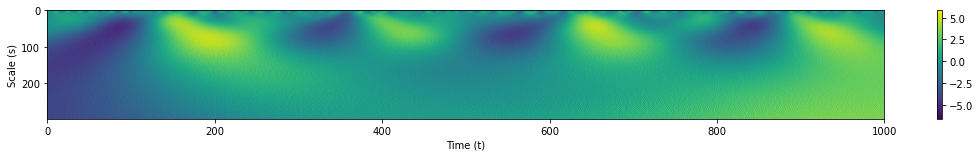

In [312]:
coeffs, freqs = pywt.cwt(s1, range(1,300), wavelet='gaus1')
plt.subplots(figsize=(18.75, 2))
plt.xlim(left=0, right=1000)
plt.ylabel('Scale (s)')
plt.xlabel('Time (t)')
plt.imshow(coeffs, aspect='auto')
plt.colorbar();

Regions of high magnitudes for our WT coefficients are still clearly visible albeit with minior interference from the white noise at smaller scales. 

In general, choosing the mother wavelet depends on what kind of behavior you want or expect in your time series. Another popular mother wavelet used to identify sine waves in time series is the "Morlet" wavelet. This wavelet is a sine wave tapered by a Gaussian wave.

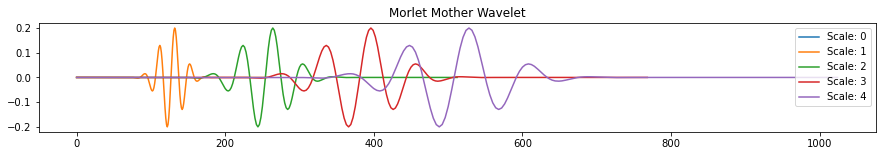

In [314]:
fig, ax = plt.subplots(figsize=(15, 2))
wav2 = pywt.ContinuousWavelet('morl')
int_psi2, x = pywt.integrate_wavelet(wav2)
for s in range(5):
    ax.plot(rescale(int_psi2, scale=s), label='Scale: '+ str(s))
    ax.set_title('Morlet Mother Wavelet')
    ax.legend()

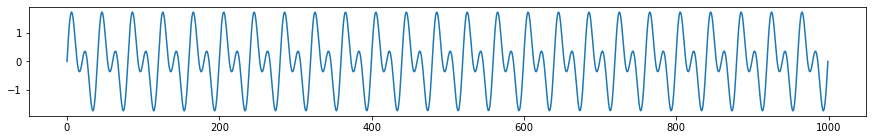

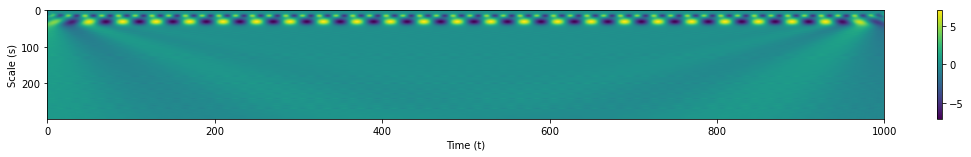

In [315]:
sine5 = sine_wave(freq=5, duration =5, plot=False)[1]
sine10 = sine_wave(freq=10, plot=False)[1]
sine_5_10 = sine5+sine10
plt.subplots(figsize=(15, 2))
plt.plot(sine_5_10)
plt.show()
plt.subplots(figsize=(18.75, 2))
plt.xlim(left=0, right=1000)
plt.ylabel('Scale (s)')
plt.xlabel('Time (t)')
coeffs, freqs = pywt.cwt(sine_5_10, range(1,300), wavelet='Morl')
plt.imshow(coeffs, aspect='auto')
plt.colorbar();

### Example: Using Accelerometer and Gyroscopic Data

The following code is taken from:

https://towardsdatascience.com/multiple-time-series-classification-by-using-continuous-wavelet-transformation-d29df97c0442

The following data contains time signals of accelerometer and gyroscopic data attached to people performing different activities. Throughout the duration of their activity, measurements were taken from the devices and recorded as time series. Each time series depicts a different activity.

In [6]:
def load_y_data(y_path):
    y = np.loadtxt(y_path, dtype=np.int32).reshape(-1, 1)
    # change labels range from 1-6 t 0-5, this enables a sparse_categorical_crossentropy loss function
    return y - 1


def load_X_data(X_path):
    X_signal_paths = [X_path + file for file in os.listdir(X_path)]
    X_signals = [np.loadtxt(path, dtype=np.float32) for path in X_signal_paths]
    return np.transpose(np.array(X_signals), (1, 2, 0))


PATH = 'data/'
LABEL_NAMES = ["Walking", "Walking upstairs",
               "Walking downstairs", "Sitting", "Standing", "Laying"]

# load X data
X_train = load_X_data(PATH + 'train/Inertial Signals/')
X_test = load_X_data(PATH + 'test/Inertial Signals/')
# load y label
y_train = load_y_data(PATH + 'train/y_train.txt')
y_test = load_y_data(PATH + 'test/y_test.txt')

Quite evidently, we find that walking has a different "look" from that of simply laying down. Humans can easily determine this at a glance but can be difficult for machines to differentiate between the two signals. The WT allows for the creation of images that contain temporal and frequency information providing a compact and meaningful representation of these time series.

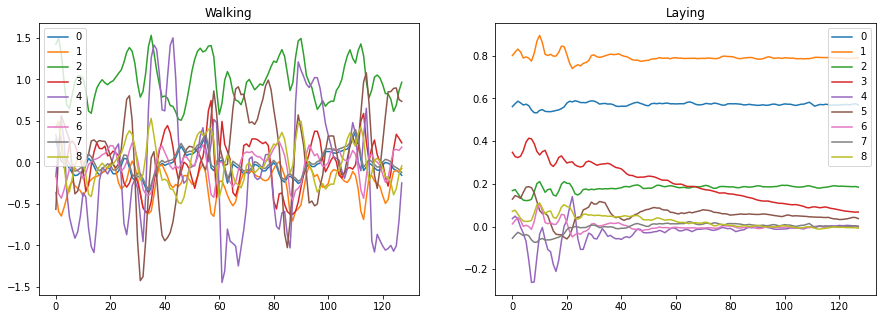

In [7]:
fig, ax = plt.subplots(ncols=2, figsize=(15, 5))
pd.DataFrame(X_train[79]).plot(ax=ax[0], title='Walking')
pd.DataFrame(X_train[51]).plot(ax=ax[1], title='Laying');

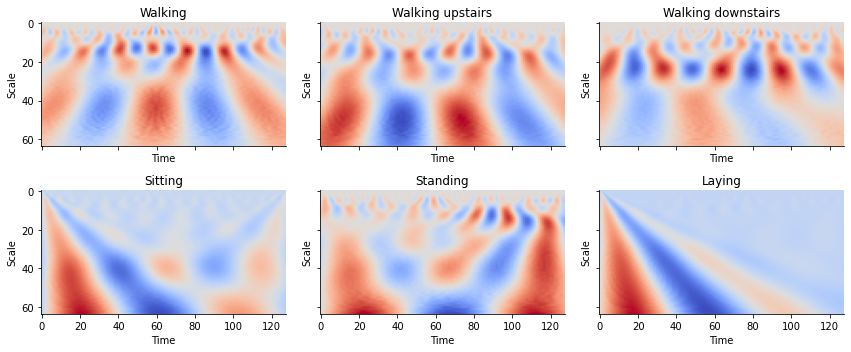

In [8]:
def split_indices_per_label(y):
    indicies_per_label = [[] for x in range(0, 6)]
    # loop over the six labels
    for i in range(6):
        indicies_per_label[i] = np.where(y == i)[0]
    return indicies_per_label


def plot_cwt_coeffs_per_label(X, label_indicies, label_names, signal, sample, scales, wavelet):

    fig, axs = plt.subplots(nrows=2, ncols=3, sharex=True,
                            sharey=True, figsize=(12, 5))

    for ax, indices, name in zip(axs.flat, label_indicies, label_names):
        coeffs, freqs = pywt.cwt(
            X[indices[sample], :, signal], scales, wavelet=wavelet)
        ax.imshow(coeffs, cmap='coolwarm', aspect='auto')
        ax.set_title(name)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.set_ylabel('Scale')
        ax.set_xlabel('Time')
    plt.tight_layout()


train_labels_indicies = split_indices_per_label(y_train)

# signal indicies: 0 = body acc x, 1 = body acc y, 2 = body acc z, 3 = body gyro x, 4 = body gyro y, 5 = body gyro z, 6 = total acc x, 7 = total acc y, 8 = total acc z
signal = 3  # signal index
sample = 1  # sample index of each label indicies list
scales = np.arange(1, 65)  # range of scales
wavelet = 'morl'  # mother wavelet

plot_cwt_coeffs_per_label(X_train, train_labels_indicies, LABEL_NAMES, signal,
                          sample, scales, wavelet)

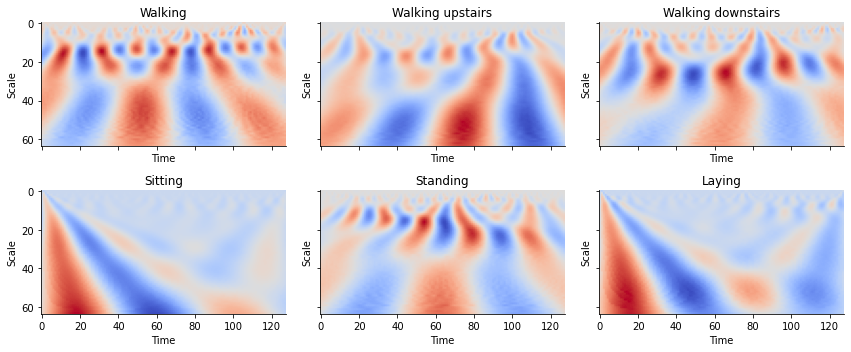

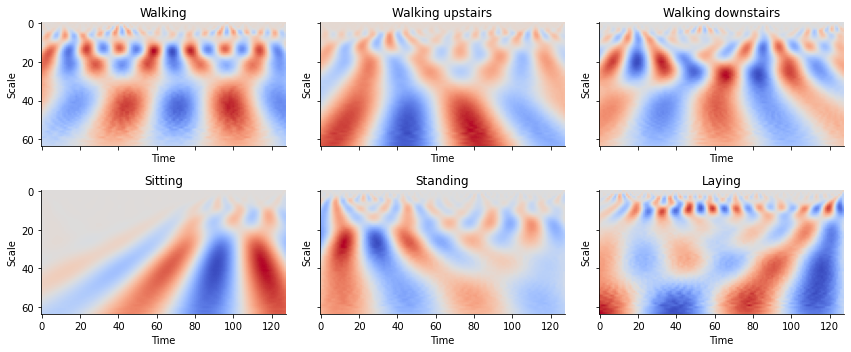

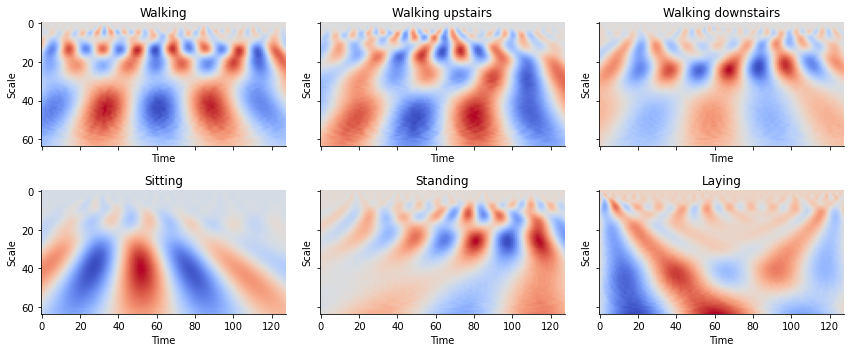

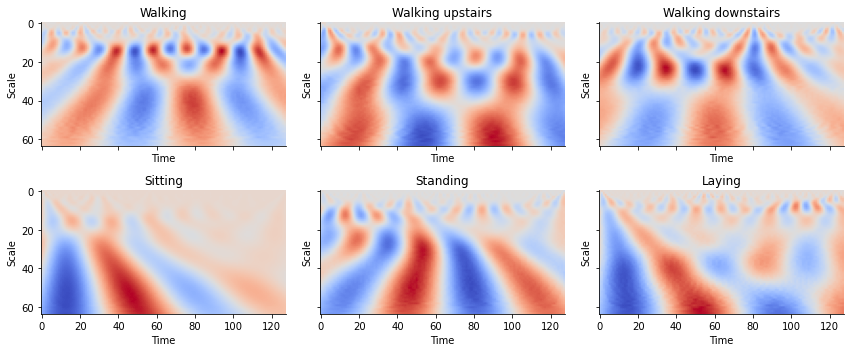

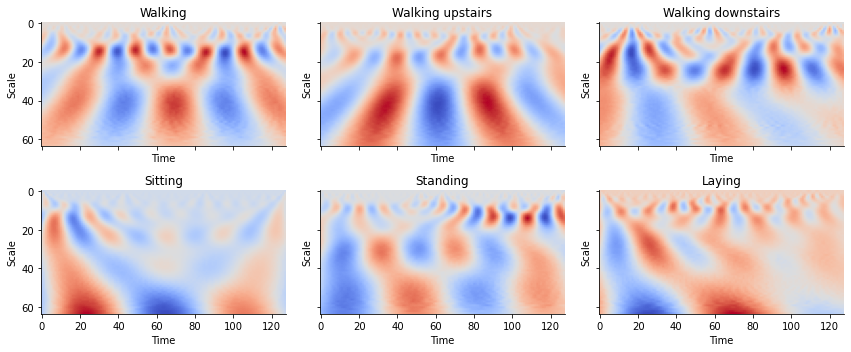

In [9]:
for sample in range(2, 7):
    plot_cwt_coeffs_per_label(X_train, train_labels_indicies, LABEL_NAMES,
                              signal, sample, scales, wavelet)

Looking at the plots for each activity, we see can see some patterns between the images. By feeding these results into a convolutional neural network, we can create a classifier to classify time series into activities.

## SUMMARY
In this notebook, we discussed the fundamentals of Fourier and Wavelet Transform to look at cyclical and repeating patterns from our time-series data. Fourier Transform breaks down our given time series into sinusoidal components while wavelet transform identifies pulses or discrete patterns by scanning a reference signal (mother wavelet) accross our time-series.

Although these two methods does not explicitly predict or forecast future values for our time-series, they instead provide us a another method to explore possible seasonalities and periodic patterns in our time series. They are good pre-processing steps as they can generate additional features beyond our given time series. This will especially be useful as we look at machine learning methods in the succeeding sections of this book.

#### Reference and acknowledgements
*This notebook is largley based on the original notebook by Gilbert Chua from PhD2023. Additional discussions on the following topics where added:*
- *Requirements and assumptions for before applying Fourier Transform*
- *Relationship of area under the curve and energy of Fourier Transforms*
- *Visual representation of fourier transform application*
- *Application to the power dataset*